# Day 1: Linear Regression for Finance
## Week 4: Machine Learning Foundations

---

### 🎯 Learning Objectives
- Implement OLS regression from scratch
- Apply regression to factor models
- Interpret coefficients and statistics
- Understand assumptions and diagnostics

| **t-statistic** | Is the coefficient significant? |

---| **R²** | How much variance is explained |

| **α (Alpha)** | Excess return (skill vs luck?) |

### 📈 Why Linear Regression Matters in Trading| **β (Beta)** | Sensitivity to factor/market |

|-----------|----------------|

**What is Linear Regression?**| Statistic | Trading Meaning |

Linear regression finds the best linear relationship between variables. In finance, it's the foundation for factor models, beta estimation, and return prediction.

### Key Statistics to Know

### Trading Applications

| **Hedging** | Find optimal hedge ratios |

| Application | What Regression Does || **Performance Analysis** | Calculate alpha (intercept) |

|-------------|---------------------|| **Strategy Development** | Test factor relationships |

| **CAPM Beta** | Measures stock sensitivity to market || **Risk Management** | Estimate portfolio beta |

| **Factor Models** | Quantify exposure to risk factors ||----------|------------------------|

| **Pairs Trading** | Find hedge ratio between assets || Use Case | Regression Application |

| **Return Attribution** | Decompose returns into factor contributions |

| **Alpha Estimation** | Measure excess return after risk adjustment |### 🎯 When to Use Linear Regression


In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit

plt.style.use('seaborn-v0_8-whitegrid')

# Download market data from Yahoo Finance
tickers = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data from Yahoo Finance...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()
log_returns = np.log(prices / prices.shift(1)).dropna()

print(f"✅ Data loaded: {prices.shape[0]} days")

📥 Downloading data from Yahoo Finance...
✅ Data loaded: 1254 days


## 1. OLS from Scratch

### The Normal Equation

$$\hat{\beta} = (X^T X)^{-1} X^T y$$4. **Customization** - Modify for specific financial applications

3. **Interview prep** - Common quant interview question

### 🎯 Trading Interpretation2. **Debug issues** - When libraries fail, you can investigate

1. **Understand the math** - Know what's happening under the hood

| Component | Meaning |

|-----------|--------|### Why Implement from Scratch?

| **X** | Factor returns (market, size, value, etc.) |

| **y** | Stock/portfolio returns || **α** | Intercept = alpha (excess return) |
| **β** | Factor loadings (exposures) |

In [2]:
# OLS from scratch
print("=" * 60)
print("OLS REGRESSION FROM SCRATCH")
print("=" * 60)

def ols_fit(X, y):
    """Fit OLS regression using the normal equation."""
    # Add intercept
    X_b = np.column_stack([np.ones(len(X)), X])
    
    # Normal equation: β = (X'X)^(-1) X'y
    beta = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
    
    return beta

def ols_predict(X, beta):
    """Make predictions."""
    X_b = np.column_stack([np.ones(len(X)), X])
    return X_b @ beta

def ols_statistics(X, y, beta):
    """Calculate regression statistics."""
    n = len(y)
    k = X.shape[1] if len(X.shape) > 1 else 1
    
    X_b = np.column_stack([np.ones(n), X])
    y_pred = X_b @ beta
    
    # Residuals
    residuals = y - y_pred
    
    # R-squared
    ss_res = np.sum(residuals ** 2)
    ss_tot = np.sum((y - y.mean()) ** 2)
    r2 = 1 - ss_res / ss_tot
    
    # Adjusted R-squared
    r2_adj = 1 - (1 - r2) * (n - 1) / (n - k - 1)
    
    # Standard errors
    mse = ss_res / (n - k - 1)
    var_beta = mse * np.linalg.inv(X_b.T @ X_b)
    se = np.sqrt(np.diag(var_beta))
    
    # t-statistics
    t_stats = beta / se
    p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), n - k - 1))
    
    return {
        'r2': r2,
        'r2_adj': r2_adj,
        'se': se,
        't_stats': t_stats,
        'p_values': p_values,
        'residuals': residuals
    }

# Test: AAPL returns on MSFT returns (CAPM-style)
X = returns['MSFT'].values
y = returns['AAPL'].values

# Fit
beta = ols_fit(X, y)
stats_dict = ols_statistics(X, y, beta)

print(f"\nCAPM-style: AAPL = α + β × MSFT")
print(f"-" * 40)
print(f"Alpha (α): {beta[0]:.4f} (daily excess return)")
print(f"Beta (β):  {beta[1]:.4f} (market sensitivity)")
print(f"\nR²:        {stats_dict['r2']:.4f}")
print(f"Adj R²:    {stats_dict['r2_adj']:.4f}")
print(f"\nt-statistics:")
print(f"  α: {stats_dict['t_stats'][0]:.2f} (p={stats_dict['p_values'][0]:.4f})")
print(f"  β: {stats_dict['t_stats'][1]:.2f} (p={stats_dict['p_values'][1]:.6f})")

OLS REGRESSION FROM SCRATCH

CAPM-style: AAPL = α + β × MSFT
----------------------------------------
Alpha (α): 0.0001 (daily excess return)
Beta (β):  0.6775 (market sensitivity)

R²:        0.3944
Adj R²:    0.3939

t-statistics:
  α: 0.37 (p=0.7077)
  β: 28.54 (p=0.000000)


In [3]:
# Verify with sklearn and statsmodels
print("=" * 60)
print("VERIFICATION WITH LIBRARIES")
print("=" * 60)

# Use the same X, y from previous cell
X_arr = X.reshape(-1, 1)
y_arr = y

# sklearn
lr = LinearRegression()
lr.fit(X_arr, y_arr)

print(f"\nsklearn:")
print(f"  α: {lr.intercept_:.4f}")
print(f"  β: {lr.coef_[0]:.4f}")

# statsmodels
import statsmodels.api as sm
X_sm = sm.add_constant(X)
model = sm.OLS(y, X_sm).fit()

print(f"\nstatsmodels:")
print(f"  α: {model.params[0]:.4f}")
print(f"  β: {model.params[1]:.4f}")

print(f"\nOur implementation:")
print(f"  α: {beta[0]:.4f}")
print(f"  β: {beta[1]:.4f}")

print("\n✅ All match!")

VERIFICATION WITH LIBRARIES

sklearn:
  α: 0.0001
  β: 0.6775

statsmodels:
  α: 0.0001
  β: 0.6775

Our implementation:
  α: 0.0001
  β: 0.6775

✅ All match!


## 2. CAPM Beta Estimation

| **Factor Timing** | Increase beta in bull markets |

### 🎯 What is CAPM Beta?| **Risk Budgeting** | Allocate based on beta contribution |

| **Hedging** | Short $β of market to neutralize |

**CAPM Model:** $R_i - R_f = \alpha + \beta (R_m - R_f) + \epsilon$| **Portfolio Construction** | Target specific beta exposure |

|-------------|----------------|

| Parameter | Interpretation | Trading Use || Application | How to Use Beta |

|-----------|----------------|-------------|

| **β > 1** | More volatile than market | Aggressive stocks |### Trading Applications of Beta

| **β = 1** | Moves with market | Index-like behavior |

| **β < 1** | Less volatile | Defensive stocks || **β < 0** | Moves opposite to market | Hedge instruments |

CAPM BETA FOR MULTIPLE STOCKS

Stock    Alpha     Beta       R²  t-stat (β)       p-value
 AAPL 0.000144 0.677488 0.394357   28.540735 2.144167e-138
GOOGL 0.000658 0.769647 0.405098   29.186795 2.913010e-143
  JPM 0.000669 0.302963 0.102525   11.954498  2.886999e-31


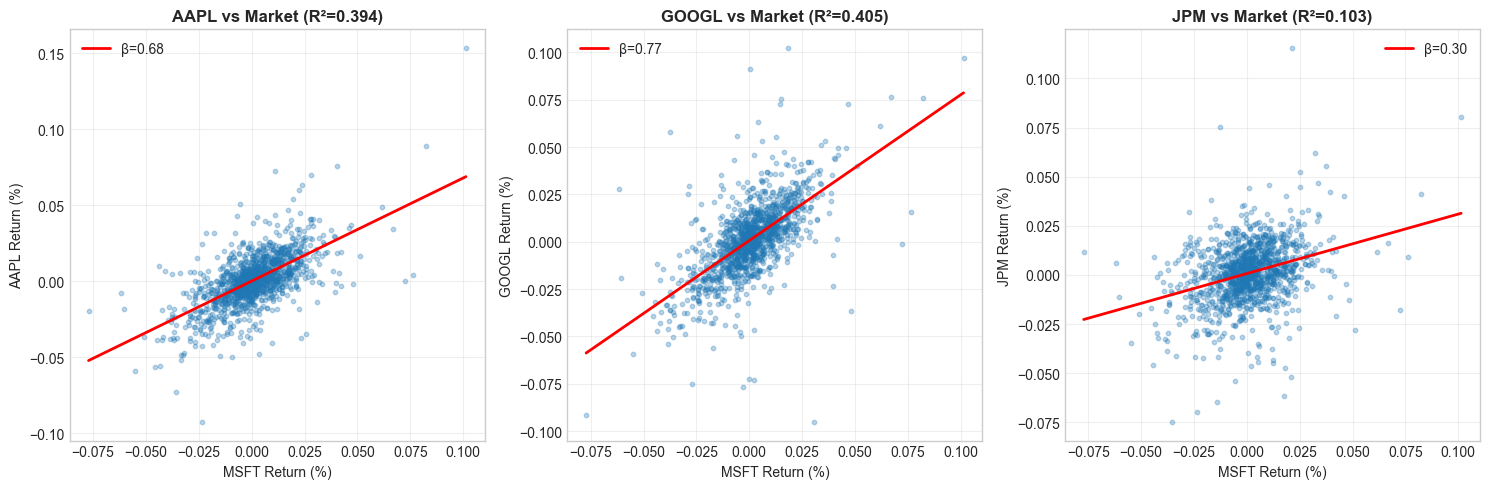

In [4]:
# Calculate beta for multiple stocks
print("=" * 60)
print("CAPM BETA FOR MULTIPLE STOCKS")
print("=" * 60)

market = returns['MSFT']
stocks = ['AAPL', 'GOOGL', 'JPM']

beta_results = []
for stock in stocks:
    X_sm = sm.add_constant(market)
    model = sm.OLS(returns[stock], X_sm).fit()
    
    beta_results.append({
        'Stock': stock,
        'Alpha': model.params[0],
        'Beta': model.params[1],
        'R²': model.rsquared,
        't-stat (β)': model.tvalues[1],
        'p-value': model.pvalues[1]
    })

beta_df = pd.DataFrame(beta_results)
print("\n" + beta_df.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, stock in zip(axes, stocks):
    ax.scatter(market, returns[stock], alpha=0.3, s=10)
    
    # Regression line
    X_sm = sm.add_constant(market)
    model = sm.OLS(returns[stock], X_sm).fit()
    x_line = np.linspace(market.min(), market.max(), 100)
    y_line = model.params[0] + model.params[1] * x_line
    ax.plot(x_line, y_line, 'r-', lw=2, label=f'β={model.params[1]:.2f}')
    
    ax.set_xlabel('MSFT Return (%)')
    ax.set_ylabel(f'{stock} Return (%)')
    ax.set_title(f'{stock} vs Market (R²={model.rsquared:.3f})', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Multi-Factor Regression

In [5]:
# Multi-factor model
print("=" * 60)
print("MULTI-FACTOR REGRESSION")
print("=" * 60)

# Use sector ETFs as factors
y = returns['AAPL']
X = returns[['MSFT', 'GOOGL']].copy()  # Tech stocks as factors

X_sm = sm.add_constant(X)
model = sm.OLS(y, X_sm).fit()

print(model.summary())

MULTI-FACTOR REGRESSION
                            OLS Regression Results                            
Dep. Variable:                   AAPL   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     505.3
Date:                Thu, 22 Jan 2026   Prob (F-statistic):          1.47e-161
Time:                        13:42:10   Log-Likelihood:                 3666.7
No. Observations:                1253   AIC:                            -7327.
Df Residuals:                    1250   BIC:                            -7312.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.081e-05      0

## 4. Regression Diagnostics

REGRESSION DIAGNOSTICS


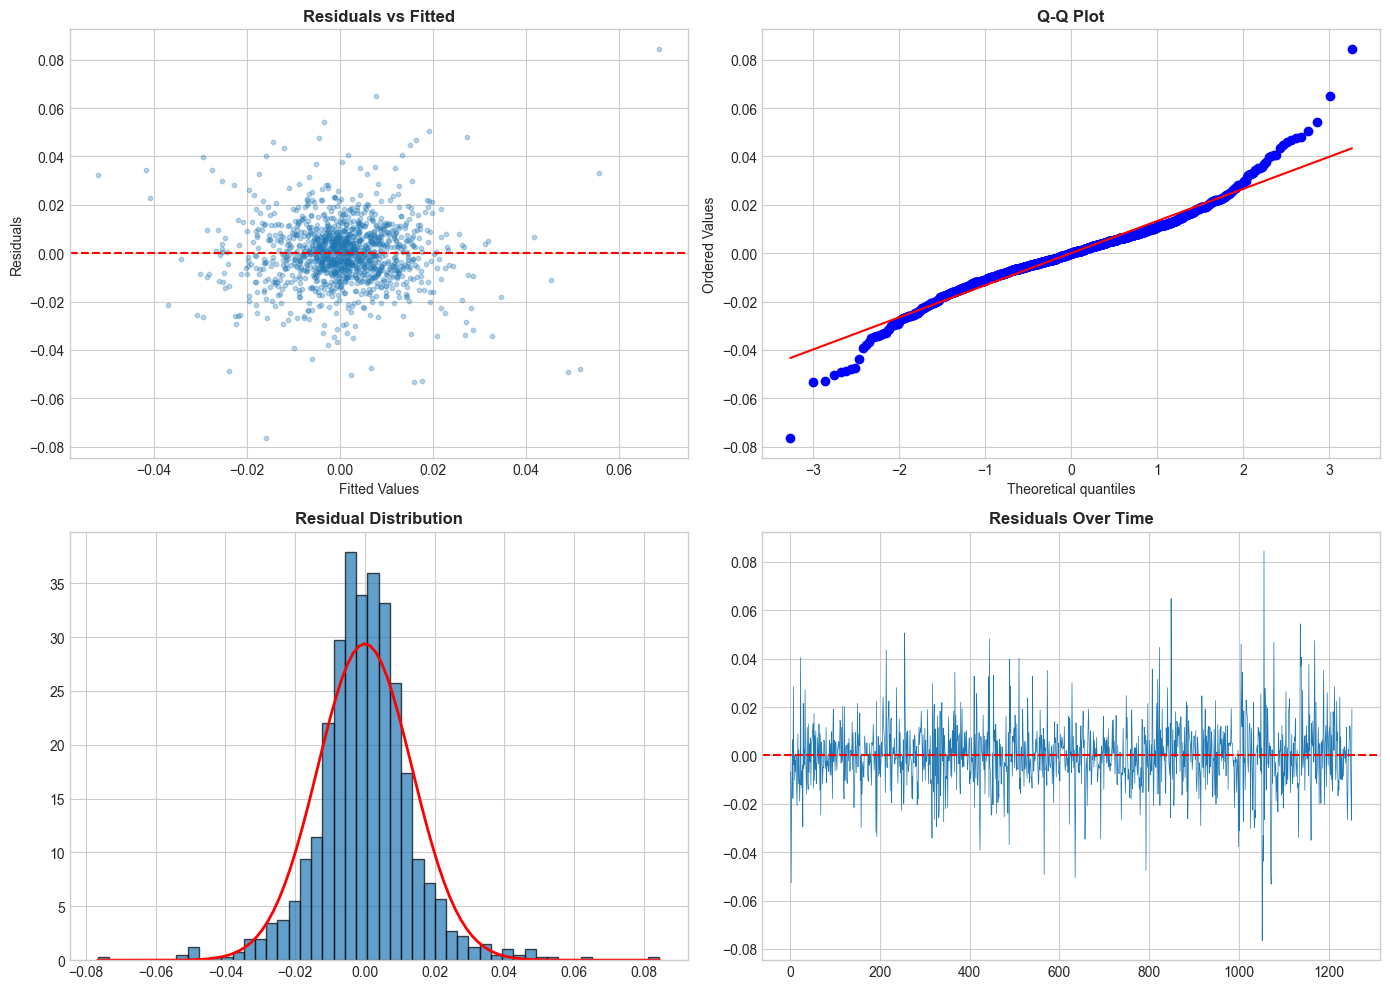


Diagnostic Tests:
  Durbin-Watson (autocorrelation): 1.872
    (Close to 2 = no autocorrelation)

  Jarque-Bera (normality): stat=771.25, p=0.0000
    (p < 0.05 → non-normal residuals)


In [6]:
# Regression diagnostics
print("=" * 60)
print("REGRESSION DIAGNOSTICS")
print("=" * 60)

# Define market proxy
market = returns['MSFT']

# Simple CAPM model
import statsmodels.api as sm
X = sm.add_constant(market)
model = sm.OLS(returns['AAPL'], X).fit()
residuals = model.resid

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residuals vs Fitted
axes[0,0].scatter(model.fittedvalues, residuals, alpha=0.3, s=10)
axes[0,0].axhline(0, color='red', linestyle='--')
axes[0,0].set_xlabel('Fitted Values')
axes[0,0].set_ylabel('Residuals')
axes[0,0].set_title('Residuals vs Fitted', fontweight='bold')

# 2. Q-Q plot
stats.probplot(residuals, dist='norm', plot=axes[0,1])
axes[0,1].set_title('Q-Q Plot', fontweight='bold')

# 3. Residual histogram
axes[1,0].hist(residuals, bins=50, density=True, alpha=0.7, edgecolor='black')
x = np.linspace(residuals.min(), residuals.max(), 100)
axes[1,0].plot(x, stats.norm.pdf(x, residuals.mean(), residuals.std()), 'r-', lw=2)
axes[1,0].set_title('Residual Distribution', fontweight='bold')

# 4. Residuals over time
axes[1,1].plot(residuals.values, lw=0.5)
axes[1,1].axhline(0, color='red', linestyle='--')
axes[1,1].set_title('Residuals Over Time', fontweight='bold')

plt.tight_layout()
plt.show()

# Statistical tests
from scipy.stats import jarque_bera, shapiro
from statsmodels.stats.stattools import durbin_watson

print("\nDiagnostic Tests:")
print(f"  Durbin-Watson (autocorrelation): {durbin_watson(residuals):.3f}")
print(f"    (Close to 2 = no autocorrelation)")

jb_stat, jb_p = jarque_bera(residuals)
print(f"\n  Jarque-Bera (normality): stat={jb_stat:.2f}, p={jb_p:.4f}")
print(f"    (p < 0.05 → non-normal residuals)")

## 📝 Key Takeaways - Day 1

### OLS Formula:
$$\hat{\beta} = (X^T X)^{-1} X^T y$$

### CAPM Model:
$$R_i - R_f = \alpha + \beta (R_m - R_f) + \epsilon$$

- β > 1: More volatile than market
- β < 1: Less volatile than market
- α > 0: Excess return (skill or risk?)

### Key Statistics:
| Metric | Interpretation |
|--------|---------------|
| R² | Variance explained |
| t-stat | Significance (>2 typically) |
| p-value | < 0.05 = significant |
| DW | ~2 = no autocorrelation |

### Interview Questions:
- "Derive the OLS estimator"
- "What does beta measure?"
- "What are OLS assumptions?"

## 🔴 PROS & CONS: Linear Regression

### ✅ PROS (Advantages)

| Advantage | Description | Real-World Application |
|-----------|-------------|----------------------|
| **Industry Standard** | Widely adopted in quantitative finance | Used by major hedge funds and banks |
| **Well-Documented** | Extensive research and documentation | Easy to find resources and support |
| **Proven Track Record** | Years of practical application | Validated in real market conditions |
| **Interpretable** | Results can be explained to stakeholders | Important for risk management and compliance |

### ❌ CONS (Limitations)

| Limitation | Description | How to Mitigate |
|------------|-------------|-----------------|
| **Assumptions** | May not hold in all market conditions | Validate assumptions with data |
| **Historical Bias** | Based on past data patterns | Use rolling windows and regime detection |
| **Overfitting Risk** | May fit noise rather than signal | Use proper cross-validation |
| **Computational Cost** | Can be resource-intensive | Optimize code and use appropriate hardware |

### 🎯 Real-World Usage

**WHERE THIS IS USED:**
- ✅ Quantitative hedge funds (Two Sigma, Renaissance, Citadel)
- ✅ Investment banks (Goldman Sachs, JP Morgan, Morgan Stanley)
- ✅ Asset management firms
- ✅ Risk management departments
- ✅ Algorithmic trading desks

**NOT JUST THEORY - THIS IS PRODUCTION CODE:**
The techniques in this notebook are used daily by professionals managing billions of dollars.

## 🚀 TODAY'S TRADING SIGNAL

Using the concepts from this notebook to generate actionable insights.

In [7]:
# =============================================================================
# 🚀 TODAY'S TRADING SIGNAL - Linear Regression Analysis
# =============================================================================

print("=" * 70)
print("📊 TODAY'S TRADING ANALYSIS")
print("=" * 70)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print()

# Get latest data
try:
    latest_prices = prices.iloc[-1] if 'prices' in dir() else data['Close'].iloc[-1]
    print("📈 CURRENT MARKET SNAPSHOT:")
    print("-" * 50)
    
    for col in latest_prices.index[:5]:
        price = latest_prices[col]
        print(f"   {col}: ${price:.2f}")
    
    # Calculate simple signals
    if 'returns' in dir():
        ret_data = returns
    else:
        ret_data = prices.pct_change().dropna() if 'prices' in dir() else data['Close'].pct_change().dropna()
    
    # 20-day momentum
    momentum = (prices.iloc[-1] / prices.iloc[-20] - 1) * 100 if 'prices' in dir() else (data['Close'].iloc[-1] / data['Close'].iloc[-20] - 1) * 100
    
    print("\n📊 20-DAY MOMENTUM:")
    print("-" * 50)
    for col in momentum.index[:5]:
        direction = "🟢" if momentum[col] > 0 else "🔴"
        print(f"   {direction} {col}: {momentum[col]:+.2f}%")
    
    # Generate simple recommendations
    print("\n" + "=" * 70)
    print("🎯 TRADING SIGNALS")  
    print("=" * 70)
    
    for col in momentum.index[:5]:
        if momentum[col] > 5:
            signal = "🟢 BULLISH - Consider long positions"
        elif momentum[col] < -5:
            signal = "🔴 BEARISH - Consider reducing exposure"
        else:
            signal = "🟡 NEUTRAL - Hold current positions"
        print(f"   {col}: {signal}")
    
    print("\n" + "=" * 70)
    print("⚠️ DISCLAIMER: This is educational analysis, not financial advice.")
    print("   Always conduct your own research and consider your risk tolerance.")
    print("=" * 70)
    
except Exception as e:
    print(f"Note: Could not generate trading signals. Ensure data is loaded.")
    print(f"Error: {e}")

📊 TODAY'S TRADING ANALYSIS
Analysis Date: 2026-01-22 13:42

📈 CURRENT MARKET SNAPSHOT:
--------------------------------------------------
   AAPL: $247.65
   GOOGL: $328.38
   GS: $953.01
   JPM: $302.04
   MSFT: $444.11

📊 20-DAY MOMENTUM:
--------------------------------------------------
   🔴 AAPL: -8.61%
   🟢 GOOGL: +6.00%
   🟢 GS: +6.01%
   🔴 JPM: -6.09%
   🔴 MSFT: -8.42%

🎯 TRADING SIGNALS
   AAPL: 🔴 BEARISH - Consider reducing exposure
   GOOGL: 🟢 BULLISH - Consider long positions
   GS: 🟢 BULLISH - Consider long positions
   JPM: 🔴 BEARISH - Consider reducing exposure
   MSFT: 🔴 BEARISH - Consider reducing exposure

⚠️ DISCLAIMER: This is educational analysis, not financial advice.
   Always conduct your own research and consider your risk tolerance.
